# 🏉 Predicting the Scores of the Postponed 2020 Rugby Six Nations Matches

Here's a short analysis using Rugby Six Nations data.

In [239]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor

# data source = http://stats.espnscrum.com/scrum/rugby/series/index.html?trophy=2

In [240]:
url_list = [
    'http://stats.espnscrum.com/six-nations-2000/rugby/series/18482.html?template=results',
    'http://stats.espnscrum.com/six-nations-2001/rugby/series/18532.html?template=results',
    'http://stats.espnscrum.com/six-nations-2002/rugby/series/18581.html?template=results',
    'http://stats.espnscrum.com/six-nations-2003/rugby/series/18625.html?template=results',
    'http://stats.espnscrum.com/six-nations-2004/rugby/series/18671.html?template=results',
    'http://stats.espnscrum.com/six-nations-2005/rugby/series/18718.html?template=results',
    'http://stats.espnscrum.com/six-nations-2006/rugby/series/18769.html?template=results',
    'http://stats.espnscrum.com/six-nations-2007/rugby/series/18815.html?template=results',
    'http://stats.espnscrum.com/six-nations-2008/rugby/series/18853.html?template=results',
    'http://stats.espnscrum.com/six-nations-2009/rugby/series/100061.html?template=results',
    'http://stats.espnscrum.com/sixnations/rugby/series/94942.html?template=results',
    'http://stats.espnscrum.com/sixnations2011/rugby/series/114113.html?template=results',
    'http://stats.espnscrum.com/six-nations-2012/rugby/series/133755.html?template=results',
    'http://stats.espnscrum.com/six-nations-2013/rugby/series/133756.html?template=results',
    'http://stats.espnscrum.com/six-nations-2014/rugby/series/180658.html?template=results',
    'http://stats.espnscrum.com/six-nations-2015/rugby/series/180659.html?template=results',
    'http://stats.espnscrum.com/six-nations-2016/rugby/series/254969.html?template=results',
    'http://stats.espnscrum.com/scrum/rugby/series/254971.html?template=results',
    'http://stats.espnscrum.com/scrum/rugby/series/295060.html?template=results',
    'http://stats.espnscrum.com/scrum/rugby/series/295066.html?template=results',
    'http://stats.espnscrum.com/scrum/rugby/series/301888.html?template=results'
]

tmp = []

for i in url_list:
    # make a GET request to fetch the raw HTML content
    html_content = requests.get(i).text

    # parse the html content
    soup = BeautifulSoup(html_content, "lxml")
    
    # find the specific results table
    raw_table_html = str(soup.find("div", attrs={"id": "scrumArticlesBoxContent"}))
    
    # ignore the headers as they're irrelevant
    raw_table_html = raw_table_html[1346:-15]
    
    tmp.append(raw_table_html)

all_tables_html = ''.join(tmp)
all_tables_html = '<table>' + all_tables_html + '</table>'

In [241]:
# create dataframe from string html
df = pd.read_html(all_tables_html)

# read_html outputs a list of dataframes. concat them all
df = pd.concat(df)

# delete irrelevant columns
del df[1], df[3], df[4]

display(df)

,0,2
0,"Feb 5, 2000",Italy 34 - 20 Scotland
1,NaN,England 50 - 18 Ireland
2,NaN,Wales 3 - 36 France
3,"Feb 19, 2000",France 9 - 15 England
4,NaN,Wales 47 - 16 Italy
...,...,...
304,NaN,England 33 - 30 Wales
305,"Mar 8, 2020",Scotland 28 - 17 France
306,"Mar 14, 2020",Wales v Scotland
307,NaN,Italy v England


In [242]:
# fill in dates
df = df.ffill()

# rename date column
df.rename(columns={0:'date'}, inplace=True)

# split scores column
df[['home_team','away_team']] = df[2].str.split(' - ', expand=True)
del df[2]

# split score from country name
df['home_team_score'] = df.home_team.str.extract('(\d+)')
df['away_team_score'] = df.away_team.str.extract('(\d+)')
df['home_team'] = df['home_team'].str.replace(r'\d+','')
df['away_team'] = df['away_team'].str.replace(r'\d+','')
df['home_team'] = df['home_team'].str.strip()
df['away_team'] = df['away_team'].str.strip()

stadium = []

stadium_dict = {
    'Wales' : 'Millennium Stadium, Cardiff',
    'England' : 'Twickenham Stadium, London',
    'Scotland' : 'Murrayfield, Edinburgh',
    'Ireland' : 'Lansdowne Road, Dublin',
    'Italy' : 'Stadio Flaminio, Rome',
    'France' : 'Stade de France, Paris'}

# append stadium name to country name
for i in df.values.tolist():
    stadium.append(stadium_dict.get(i[1]))

df['stadium'] = stadium

display(df)

,date,home_team,away_team,home_team_score,away_team_score,stadium
0,"Feb 5, 2000",Italy,Scotland,34,20,"Stadio Flaminio, Rome"
1,"Feb 5, 2000",England,Ireland,50,18,"Twickenham Stadium, London"
2,"Feb 5, 2000",Wales,France,3,36,"Millennium Stadium, Cardiff"
3,"Feb 19, 2000",France,England,9,15,"Stade de France, Paris"
4,"Feb 19, 2000",Wales,Italy,47,16,"Millennium Stadium, Cardiff"
...,...,...,...,...,...,...
304,"Mar 7, 2020",England,Wales,33,30,"Twickenham Stadium, London"
305,"Mar 8, 2020",Scotland,France,28,17,"Murrayfield, Edinburgh"
306,"Mar 14, 2020",Wales v Scotland,None,NaN,NaN,None
307,"Mar 14, 2020",Italy v England,None,NaN,NaN,None


In [243]:
training = df[df['home_team_score'].notnull()]
testing = df[df['home_team_score'].isnull()]

testing = testing.copy()

# split score from country name
testing[['home_team','away_team']] = testing['home_team'].str.split(' v ', expand=True)

stadium = []

for i in testing.values.tolist():
    stadium.append(stadium_dict.get(i[1]))

testing['stadium'] = stadium

display(testing)

,date,home_team,away_team,home_team_score,away_team_score,stadium
303,"Mar 7, 2020",Ireland,Italy,NaN,NaN,"Lansdowne Road, Dublin"
306,"Mar 14, 2020",Wales,Scotland,NaN,NaN,"Millennium Stadium, Cardiff"
307,"Mar 14, 2020",Italy,England,NaN,NaN,"Stadio Flaminio, Rome"
308,"Mar 14, 2020",France,Ireland,NaN,NaN,"Stade de France, Paris"


In [244]:
training = training.copy()
training[['home_team_score', 'away_team_score']].astype(int)

winner = []

# assign win, draw or lose to the outcome

for i in training.values.tolist():
    if i[3] > i[4]:
        winner.append(i[1])
    elif i[4] > i[3]:
        winner.append(i[2])
    else:
        winner.append('Draw')
        
training['winner'] = winner

display(training)

,date,home_team,away_team,home_team_score,away_team_score,stadium,winner
0,"Feb 5, 2000",Italy,Scotland,34,20,"Stadio Flaminio, Rome",Italy
1,"Feb 5, 2000",England,Ireland,50,18,"Twickenham Stadium, London",England
2,"Feb 5, 2000",Wales,France,3,36,"Millennium Stadium, Cardiff",France
3,"Feb 19, 2000",France,England,9,15,"Stade de France, Paris",France
4,"Feb 19, 2000",Wales,Italy,47,16,"Millennium Stadium, Cardiff",Wales
...,...,...,...,...,...,...,...
300,"Feb 22, 2020",Italy,Scotland,0,17,"Stadio Flaminio, Rome",Scotland
301,"Feb 22, 2020",Wales,France,23,27,"Millennium Stadium, Cardiff",France
302,"Feb 23, 2020",England,Ireland,24,12,"Twickenham Stadium, London",England
304,"Mar 7, 2020",England,Wales,33,30,"Twickenham Stadium, London",England


In [245]:
# split df so one row == one country
training_1 = training[['date', 'home_team', 'home_team_score', 'stadium', 'winner']].copy()
training_1['home_or_away'] = 'home'

training_2 = training[['date', 'away_team', 'away_team_score', 'stadium', 'winner']].copy()
training_2['home_or_away'] = 'away'

training_1.columns = ['date', 'team', 'score', 'stadium', 'winner', 'home_or_away']
training_2.columns = ['date', 'team', 'score', 'stadium', 'winner', 'home_or_away']

training = training_1.append(training_2, ignore_index=True)

win_or_lose = []

for i in training.values.tolist():
    if i[4] == 'Draw':
        win_or_lose.append('draw')
    elif i[1] == i[4]:
        win_or_lose.append('win')
    else:
        win_or_lose.append('lose')
        
training['win_or_lose'] = win_or_lose

training['label'] = 'training'
display(training)

,date,team,score,stadium,winner,home_or_away,win_or_lose,label
0,"Feb 5, 2000",Italy,34,"Stadio Flaminio, Rome",Italy,home,win,training
1,"Feb 5, 2000",England,50,"Twickenham Stadium, London",England,home,win,training
2,"Feb 5, 2000",Wales,3,"Millennium Stadium, Cardiff",France,home,lose,training
3,"Feb 19, 2000",France,9,"Stade de France, Paris",France,home,win,training
4,"Feb 19, 2000",Wales,47,"Millennium Stadium, Cardiff",Wales,home,win,training
...,...,...,...,...,...,...,...,...
605,"Feb 22, 2020",Scotland,17,"Stadio Flaminio, Rome",Scotland,away,win,training
606,"Feb 22, 2020",France,27,"Millennium Stadium, Cardiff",France,away,win,training
607,"Feb 23, 2020",Ireland,12,"Twickenham Stadium, London",England,away,lose,training
608,"Mar 7, 2020",Wales,30,"Twickenham Stadium, London",England,away,lose,training


In [246]:
# categories win or lose and home or away for correlation analysis

training['win_or_lose_cat'] = training['win_or_lose'].astype('category').cat.codes
training['home_or_away_cat'] = training['home_or_away'].astype('category').cat.codes

corr_df = training[['home_or_away_cat', 'win_or_lose_cat']]
corr = corr_df.corr()

print(corr)

del training['win_or_lose_cat'] , training['home_or_away_cat']

                  home_or_away_cat  win_or_lose_cat
home_or_away_cat          1.000000         0.120789
win_or_lose_cat           0.120789         1.000000


Total number of games played:  100


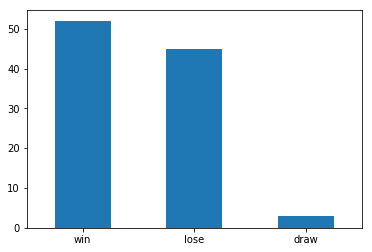

In [247]:
# focus on wales only and count the total number of times they've won and lost

wales = training.loc[training['team'] == "Wales"]

print("Total number of games played: ", len(wales.index))

wales['win_or_lose'].value_counts().plot(kind='bar', rot=0)

Total number of games played at home:  49


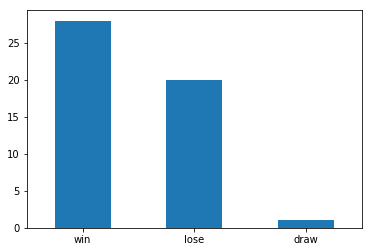

In [248]:
# focus on wales only and count the total number of times they've won and lost at home

wales_home = wales.loc[wales['home_or_away'] == "home"]

print("Total number of games played at home: ", len(wales_home.index))

wales_home['win_or_lose'].value_counts().plot(kind='bar', rot=0)

Total number of games played away:  51
lose    25
win     24
draw     2
Name: win_or_lose, dtype: int64


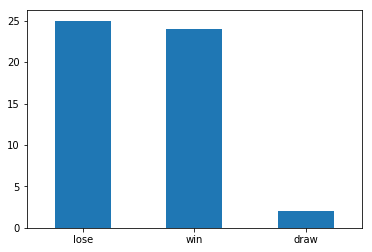

In [249]:
# focus on wales only and count the total number of times they've won and lost away

wales_away = wales.loc[wales['home_or_away'] == "away"]

print("Total number of games played away: ", len(wales_away.index))
print(wales_away['win_or_lose'].value_counts())
wales_away['win_or_lose'].value_counts().plot(kind='bar', rot=0)

In [250]:
# split testingdf so one row == one country

testing_1 = testing[['date', 'home_team', 'stadium']].copy()
testing_1['home_or_away'] = 'home'

testing_2 = testing[['date', 'away_team', 'stadium']].copy()
testing_2['home_or_away'] = 'away'

testing_1.columns = ['date', 'team', 'stadium', 'home_or_away']
testing_2.columns = ['date', 'team', 'stadium', 'home_or_away']

testing = testing_1.append(testing_2, ignore_index=True)

testing['label'] = 'testing'

testing_for_display = testing[['date', 'team', 'stadium', 'home_or_away']].copy()

In [251]:
# combine testing and training so we can encode the headers evenly

combined = training.append(testing, ignore_index=True)
combined = pd.get_dummies(combined, columns=['team', 'stadium', 'home_or_away'])

display(combined)

,date,score,winner,win_or_lose,label,team_England,team_France,team_Ireland,team_Italy,team_Scotland,team_Wales,"stadium_Lansdowne Road, Dublin","stadium_Millennium Stadium, Cardiff","stadium_Murrayfield, Edinburgh","stadium_Stade de France, Paris","stadium_Stadio Flaminio, Rome","stadium_Twickenham Stadium, London",home_or_away_away,home_or_away_home
0,"Feb 5, 2000",34,Italy,win,training,0,0,0,1,0,0,0,0,0,0,1,0,0,1
1,"Feb 5, 2000",50,England,win,training,1,0,0,0,0,0,0,0,0,0,0,1,0,1
2,"Feb 5, 2000",3,France,lose,training,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,"Feb 19, 2000",9,France,win,training,0,1,0,0,0,0,0,0,0,1,0,0,0,1
4,"Feb 19, 2000",47,Wales,win,training,0,0,0,0,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,"Mar 14, 2020",NaN,NaN,NaN,testing,0,1,0,0,0,0,0,0,0,1,0,0,0,1
614,"Mar 7, 2020",NaN,NaN,NaN,testing,0,0,0,1,0,0,1,0,0,0,0,0,1,0
615,"Mar 14, 2020",NaN,NaN,NaN,testing,0,0,0,0,1,0,0,1,0,0,0,0,1,0
616,"Mar 14, 2020",NaN,NaN,NaN,testing,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [252]:
# split them again based on the label 

training = combined.loc[combined['label'] == 'training']
testing = combined.loc[combined['label'] == 'testing']

del training['date'], training['winner'], training['win_or_lose']

# assign scores as an integer
training = training.copy()
training['score'] = training['score'].astype(int)

In [253]:
# select the headers we want to use as features and label
headers = list(training)
headers.remove('score')
headers.remove('label')

# split into training and validation set

X = training[headers].values
y = training['score'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)
y_val = y_val.astype(np.int)

In [254]:
# apply random forest resgressor and evaluate performance on validation set

model = RandomForestRegressor(n_estimators = 50, max_depth = 4)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_val, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))

Mean Absolute Error: 7.7176675089724975
Mean Squared Error: 102.13967761633975
Root Mean Squared Error: 10.106417645058004


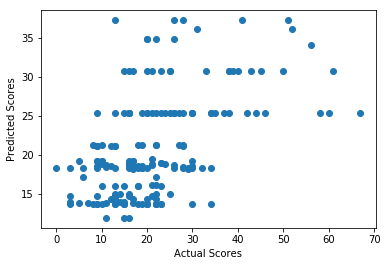

In [256]:
# plot actual against predicted scores
plt.scatter(y_val, y_pred)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.show()

In [257]:
# Apply model to unplayed matches

X_test = testing[headers].values

y_pred = model.predict(X_test)

testing_for_display['score'] = y_pred.astype(np.int)
testing_for_display = testing_for_display.sort_values('stadium', ascending=False)

display(testing_for_display)

,date,team,stadium,home_or_away,score
2,"Mar 14, 2020",Italy,"Stadio Flaminio, Rome",home,13
6,"Mar 14, 2020",England,"Stadio Flaminio, Rome",away,36
3,"Mar 14, 2020",France,"Stade de France, Paris",home,25
7,"Mar 14, 2020",Ireland,"Stade de France, Paris",away,19
1,"Mar 14, 2020",Wales,"Millennium Stadium, Cardiff",home,25
5,"Mar 14, 2020",Scotland,"Millennium Stadium, Cardiff",away,16
0,"Mar 7, 2020",Ireland,"Lansdowne Road, Dublin",home,25
4,"Mar 7, 2020",Italy,"Lansdowne Road, Dublin",away,11
